In [1]:
# %pip install category-encoders
# %pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from datetime import datetime, timedelta
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [3]:
customer_feedback = pd.read_csv("../datasets/blinkit_customer_feedback.csv")
customer = pd.read_csv("../datasets/blinkit_customers.csv")
inventory = pd.read_csv("../datasets/blinkit_inventory.csv")
order_items = pd.read_csv("../datasets/blinkit_order_items.csv")
orders = pd.read_csv("../datasets/blinkit_orders.csv")

In [4]:
sales_forecasting = orders.copy()


In [8]:
sales_forecasting.rename(columns={"order_total":"total_sum"}, inplace=True)
sales_forecasting.head()

,order_id,customer_id,order_date,promised_delivery_time,actual_delivery_time,delivery_status,total_sum,payment_method,delivery_partner_id,store_id,customer_segment,total_orders,sentiment
0,1961864118,30065862,2024-07-17 08:34:01,2024-07-17 08:52:01,2024-07-17 08:47:01,On Time,3197.07,Cash,63230,4771,Regular,13,Neutral
1,1961864118,30065862,2024-07-17 08:34:01,2024-07-17 08:52:01,2024-07-17 08:47:01,On Time,3197.07,Cash,63230,4771,Regular,13,Negative
2,1961864118,30065862,2024-07-17 08:34:01,2024-07-17 08:52:01,2024-07-17 08:47:01,On Time,3197.07,Cash,63230,4771,Regular,13,Negative
3,1549769649,9573071,2024-05-28 13:14:29,2024-05-28 13:25:29,2024-05-28 13:27:29,On Time,976.55,Cash,14983,7534,New,5,Negative
4,1549769649,9573071,2024-05-28 13:14:29,2024-05-28 13:25:29,2024-05-28 13:27:29,On Time,976.55,Cash,14983,7534,New,5,Negative


In [7]:
#1. Merge customers & feedback data

sales_forecasting = sales_forecasting.merge(customer[['customer_id', 'customer_segment', 'total_orders']], on='customer_id', how='left')
sales_forecasting = sales_forecasting.merge(customer_feedback[['customer_id', 'sentiment']], on='customer_id', how='left')

In [11]:
#2. Convert dates to datetime and standardize format
sales_forecasting['order_date'] = pd.to_datetime(sales_forecasting['order_date']).dt.date
inventory['date'] = pd.to_datetime(inventory['date'], dayfirst=True).dt.date


In [12]:
#3. Group inventory by date to prevent duplicate stock entries
inventory_grouped = inventory.groupby('date', as_index=False)['stock_received'].sum()

In [13]:
inventory_grouped

,date,stock_received
0,2023-03-17,220
1,2023-03-18,253
2,2023-03-19,263
3,2023-03-20,229
4,2023-03-21,199
...,...,...
595,2024-11-01,291
596,2024-11-02,239
597,2024-11-03,244
598,2024-11-04,233


In [14]:
#4. Merge inventory data (now grouped) into orders
sales_forecasting = sales_forecasting.merge(inventory_grouped, left_on='order_date', right_on='date', how='left')

In [15]:
sales_forecasting['stock_received'] = sales_forecasting['stock_received'].fillna(0)

In [16]:
order_items_grouped = order_items.groupby('order_id', as_index=False).agg({'quantity': 'sum', 'unit_price': 'mean'})

In [17]:
order_items_grouped

,order_id,quantity,unit_price
0,60465,2,826.21
1,2237858,1,799.46
2,3101265,1,44.35
3,5120698,1,53.49
4,5512907,3,319.34
...,...,...,...
4995,9993542681,1,951.43
4996,9996182478,3,280.35
4997,9997121955,2,994.56
4998,9997994965,2,310.69


In [18]:
sales_forecasting= sales_forecasting.merge(order_items_grouped, on='order_id', how='left')

In [20]:

sales_forecasting.drop(columns=['order_id', 'customer_id', 'promised_delivery_time', 'actual_delivery_time',
                                  'delivery_status', 'payment_method', 'delivery_partner_id', 'store_id',"date"], inplace=True)

In [21]:
sales_forecasting['order_date'] = pd.to_datetime(sales_forecasting['order_date'])
sales_forecasting['day_of_week'] = sales_forecasting['order_date'].dt.dayofweek  # 0=Monday, 6=Sunday
sales_forecasting['month'] = sales_forecasting['order_date'].dt.month
sales_forecasting['day'] = sales_forecasting['order_date'].dt.day
sales_forecasting.drop(columns=['order_date'], inplace=True)

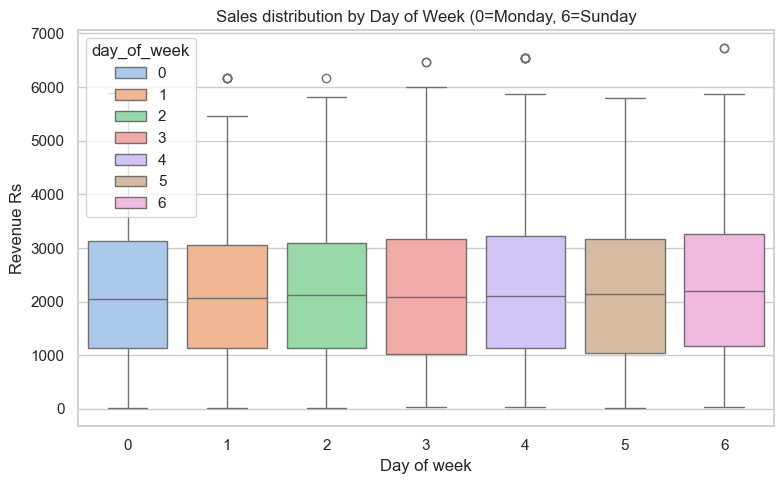

In [25]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=sales_forecasting,
    x="day_of_week",
    y="total_sum",
    palette="pastel",
    hue = "day_of_week")
plt.title("Sales distribution by Day of Week (0=Monday, 6=Sunday")
plt.xlabel("Day of week")
plt.ylabel("Revenue Rs")
plt.tight_layout()
plt.show()

In [27]:
# sentiment
sentiment_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
sales_forecasting.replace(sentiment_mapping,inplace=True)


# encoder_customer_segment
target_encoder=ce.TargetEncoder(cols="customer_segment")
sales_forecasting['customer_segment'] = target_encoder.fit_transform(
    sales_forecasting['customer_segment'], sales_forecasting['total_orders'])

# Feature Enginnering

In order to have more information and therefore a best accuracy, we are going to implement feature enginnering on our data:

- Average Revenue per Order: Measures how much revenue is generated per order.

- Revenue per Unit: Helps identify how much is earned per individual unit sold.

- Revenue Rolling Mean (7 days): Smooths short-term fluctuations to highlight longer-term trends in revenue.

- Revenue Rolling Std (7 days): Shows the variability in revenue within a 7-day window — useful for spotting unstable periods.

- Revenue Growth Rate (% change vs 7 days ago): Calculates how much revenue increased or decreased compared to the same day the previous week.

- Stock-to-Revenue Ratio: Indicates how much stock was needed to generate a certain amount of revenue — useful for efficiency tracking.

- Price Influence (Expected Revenue vs. Actual Revenue):

- expected_revenue: Unit price × quantity
- price_effect_gap: Difference between actual and expected revenue — helps detect pricing strategies, promotions or anomalies.



Finally, we drop rows with NaNs resulting from rolling calculations.

In [32]:
sales_forecasting['avg_revenue_per_order'] = sales_forecasting['total_sum'] / (sales_forecasting['total_orders'] + 1e-9)

In [34]:
sales_forecasting['revenue_per_unit'] = sales_forecasting['total_sum'] / (sales_forecasting['quantity'] + 1e-9)

In [35]:
sales_forecasting['rolling_revenue_avg_7'] = sales_forecasting['total_sum'].rolling(window=7).mean()

In [36]:
sales_forecasting['rolling_revenue_std_7'] = sales_forecasting['total_sum'].rolling(window=7).std()

In [37]:
sales_forecasting['revenue_growth_rate'] = (
    (sales_forecasting['total_sum'] - sales_forecasting['total_sum'].shift(7)) /
    (sales_forecasting['total_sum'].shift(7) + 1e-9)
)

In [39]:
sales_forecasting['stock_to_revenue_ratio'] = sales_forecasting['stock_received'] / (sales_forecasting['total_sum'] + 1e-9)

In [41]:
# Price Influence (Price × Quantity vs. Actual Revenue)
sales_forecasting['expected_revenue'] = sales_forecasting['unit_price'] * sales_forecasting['quantity']
sales_forecasting['price_effect_gap'] = sales_forecasting['total_sum'] - sales_forecasting['expected_revenue']


In [42]:
sales_forecasting.dropna(inplace=True)


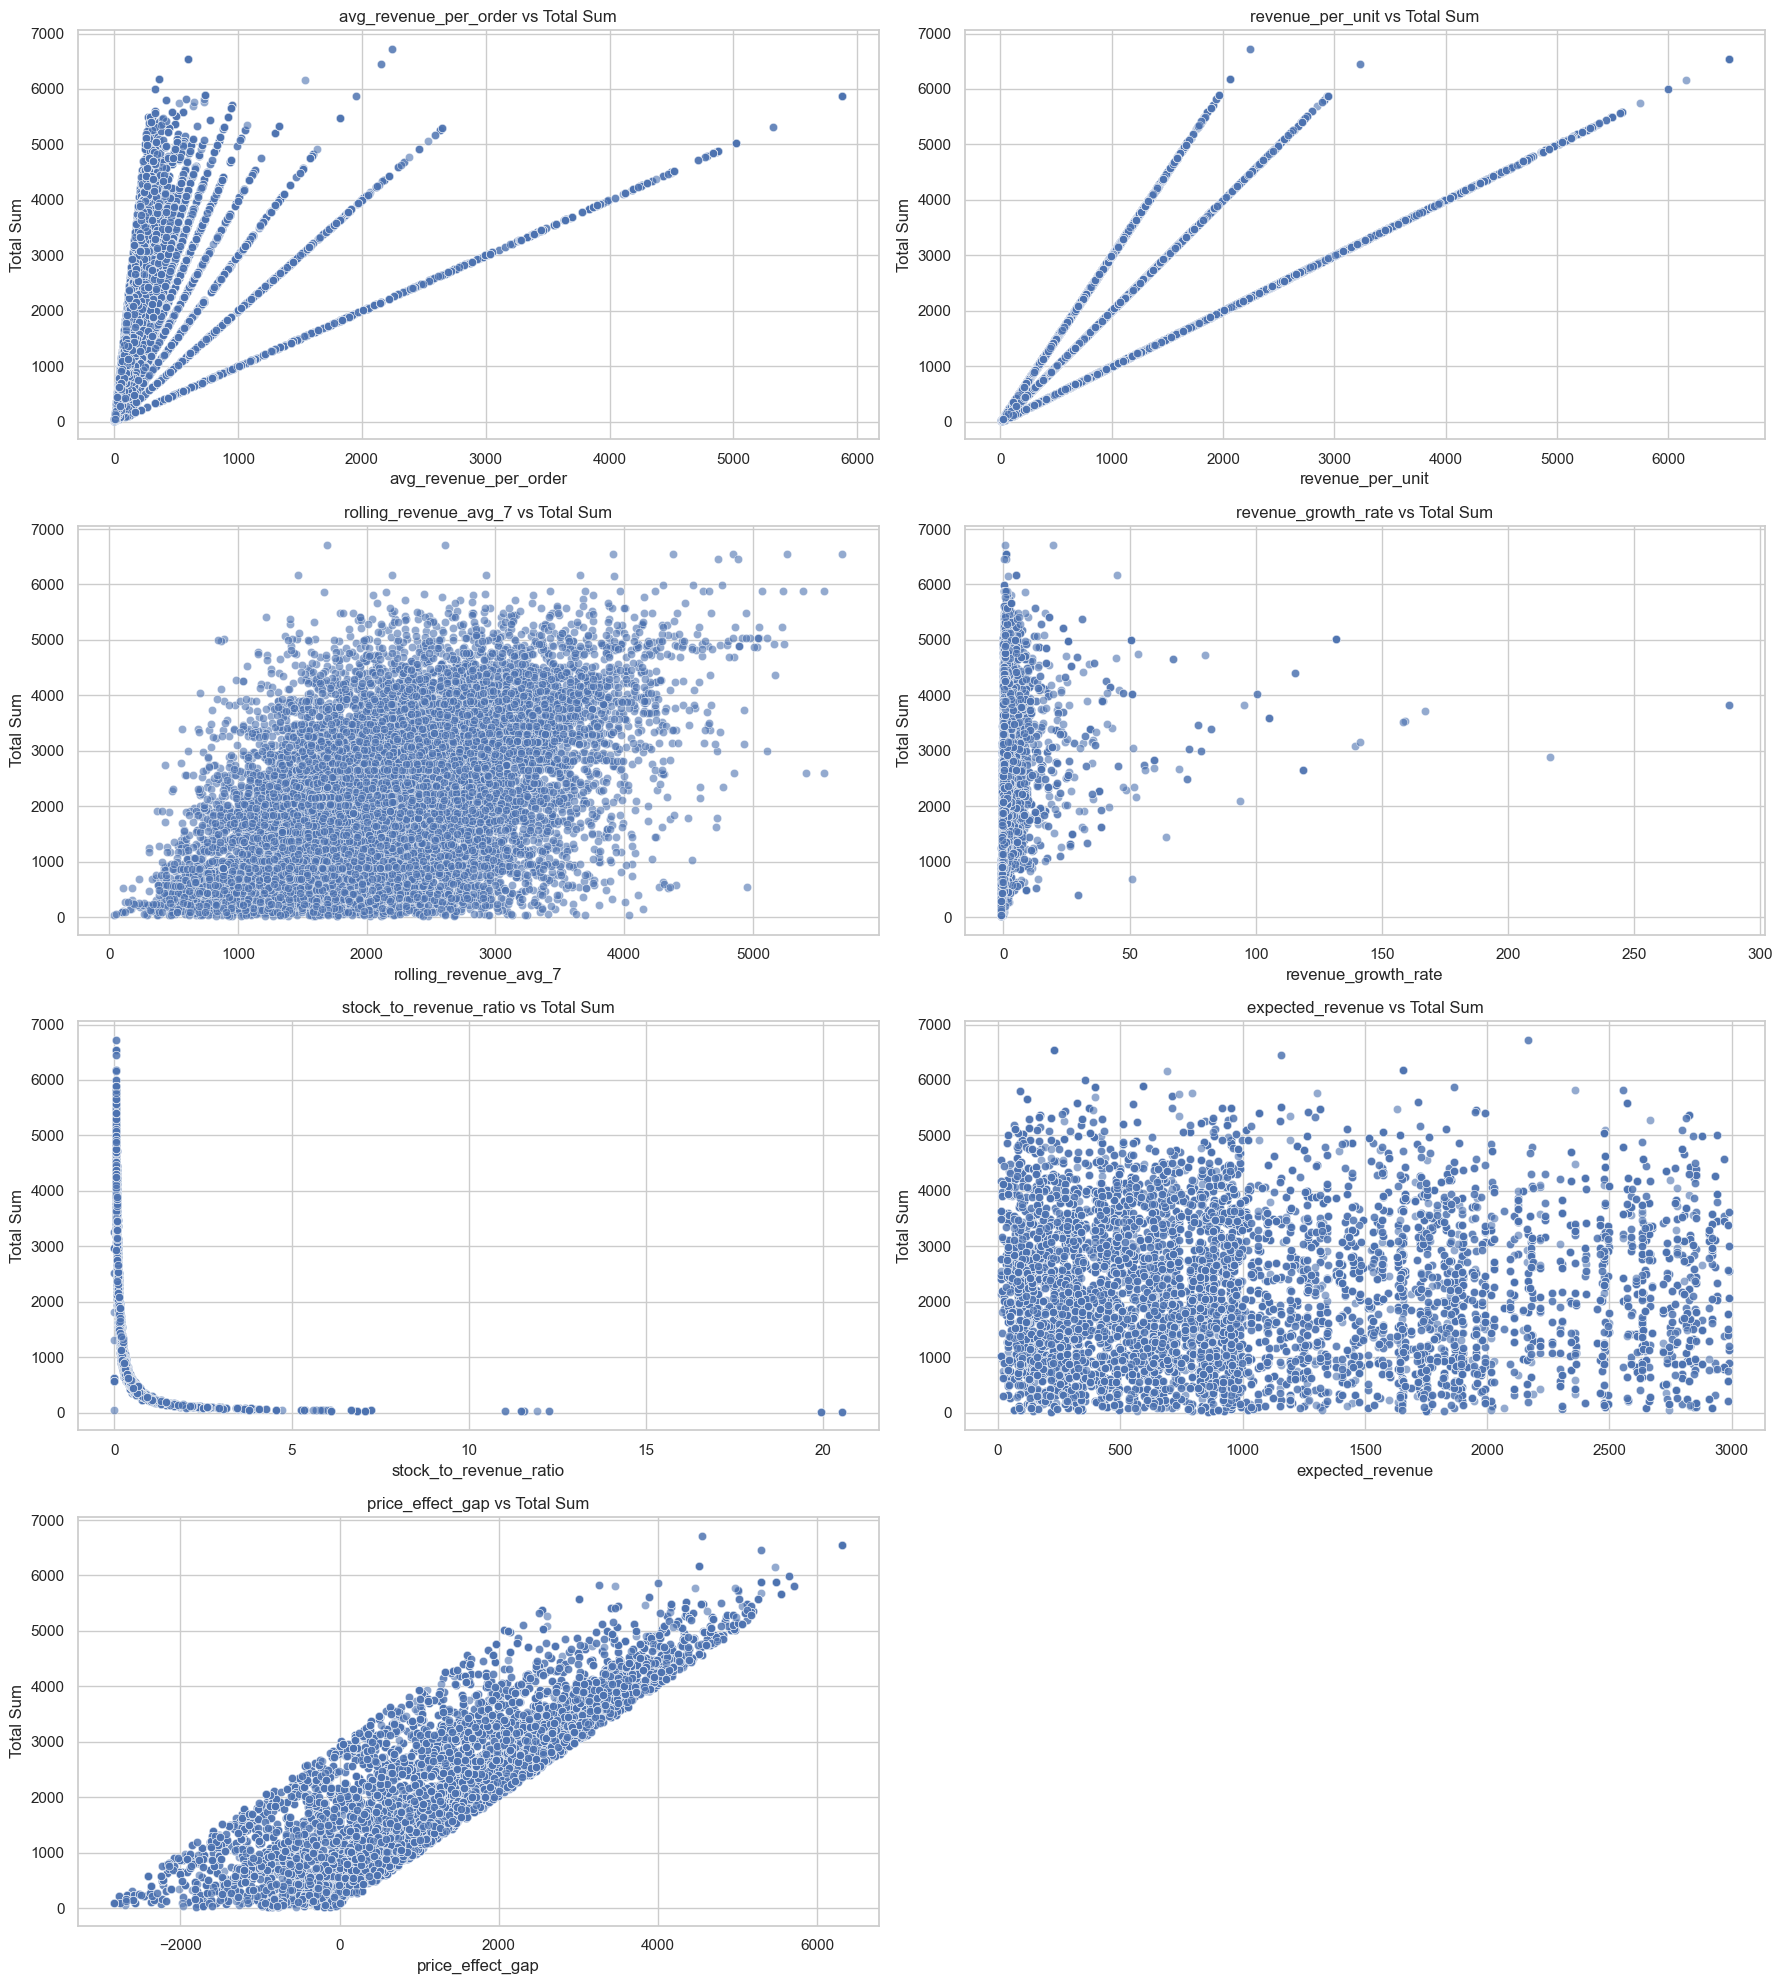

In [44]:
feature_engineered_cols = [
    'avg_revenue_per_order',
    'revenue_per_unit',
    'rolling_revenue_avg_7',
    'revenue_growth_rate',
    'stock_to_revenue_ratio',
    'expected_revenue',
    'price_effect_gap'
]

# Filtering with the target
eda_df = sales_forecasting[feature_engineered_cols + ['total_sum']].copy()

# Graph relationship with total_sum
plt.figure(figsize=(18, 20))
for i, col in enumerate(feature_engineered_cols):
    plt.subplot(4, 2, i+1)
    sns.scatterplot(data=eda_df, x=col, y='total_sum', alpha=0.6)
    plt.title(f"{col} vs Total Sum")
    plt.xlabel(col)
    plt.ylabel("Total Sum")

plt.tight_layout()
plt.show()

- avg_revenue_per_order vs Total Sum Shows a clear positive relationship — higher order values are strongly associated with higher revenue.

- revenue_per_unit vs Total sum Also displays a strong positive trend, making it a useful predictor.

- rolling_revenue_avg_7 vs Total sum Slight upward pattern, indicating a mild positive correlation over time.

- revenue_growth_rate vs Total sum Most points are centered around zero, with no clear trend — limited predictive power.

- stock_to_revenue_ratio vs Total sum Negative relationship — higher stock relative to revenue may indicate overstock or inefficiencies.

- expected_revenue vs Total sum No visible correlation — mostly reflects theoretical revenue, not actual performance.

- price_effect_gap vs Total sum Strong positive correlation — deviations in price behavior clearly impact total revenue.

## FORECASTING - PREDICTION WITH XGBOOST

In [45]:
sales_forecasting_final=sales_forecasting.copy()

sales_forecasting_final=sales_forecasting[["total_sum","day","month","day_of_week","price_effect_gap","stock_to_revenue_ratio",
                                         "revenue_growth_rate","rolling_revenue_avg_7",
                                         "revenue_per_unit","avg_revenue_per_order"]]

sales_forecasting_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14879 entries, 7 to 14885
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_sum               14879 non-null  float64
 1   day                     14879 non-null  int32  
 2   month                   14879 non-null  int32  
 3   day_of_week             14879 non-null  int32  
 4   price_effect_gap        14879 non-null  float64
 5   stock_to_revenue_ratio  14879 non-null  float64
 6   revenue_growth_rate     14879 non-null  float64
 7   rolling_revenue_avg_7   14879 non-null  float64
 8   revenue_per_unit        14879 non-null  float64
 9   avg_revenue_per_order   14879 non-null  float64
dtypes: float64(7), int32(3)
memory usage: 1.1 MB


In [47]:
X=sales_forecasting_final.drop(columns=["total_sum"])
y=sales_forecasting_final["total_sum"]

In [48]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


In [49]:
params={
        "n_estimators":[100,200,300],
        "learning_rate":[0.01,0.1,0.3,1],
        "max_depth":[1,2,5]
        }

model=XGBRegressor(objective="reg:squarederror")

grid_search=GridSearchCV(estimator=model, param_grid=params, scoring="neg_mean_absolute_error")

In [50]:
grid_search.fit(X_train,y_train)

best_model= grid_search.best_estimator_

In [51]:
best_model.fit(X_train,y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [52]:
y_pred=best_model.predict(X_test)


r2_scor=r2_score(y_test,y_pred)
print("R2 score:",r2_scor)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Display evaluation results
{"Mean Absolute Error (MAE)": mae, "Root Mean Squared Error (RMSE)": rmse}

R2 score: 0.9971040676863705


{'Mean Absolute Error (MAE)': 41.60769746823977,
 'Root Mean Squared Error (RMSE)': 70.3338007904935}

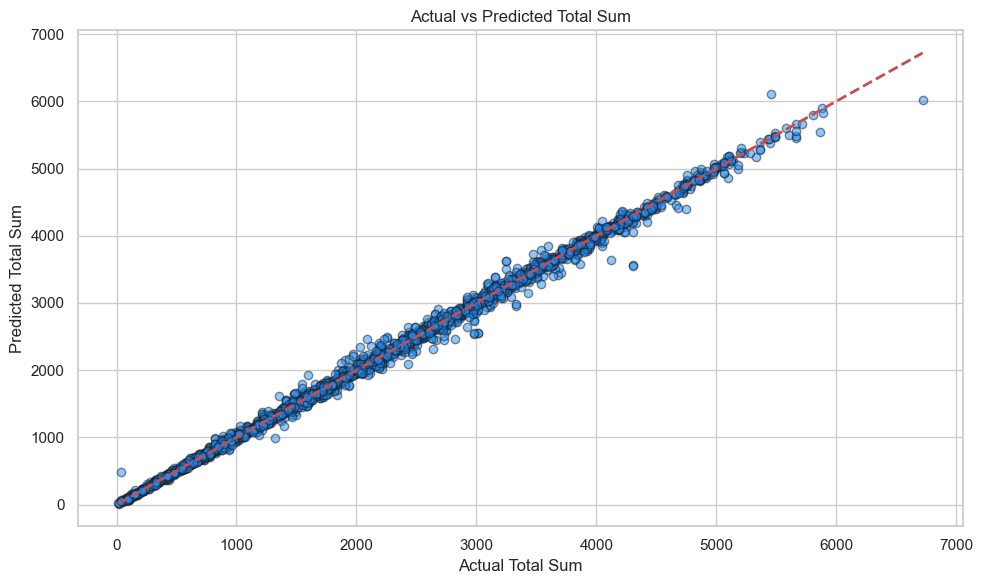

In [53]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='dodgerblue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.title("Actual vs Predicted Total Sum")
plt.xlabel("Actual Total Sum")
plt.ylabel("Predicted Total Sum")
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
import pickle

In [55]:
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(model, f)